In [136]:
import pandas as pd
import numpy as np
import xgboost as xgb
from evaluation import regression_evaluator
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def feature_selection(base_model , X_train_full, y_train):
    
    cv = KFold(n_splits=5, shuffle=True, random_state=44449999)
    rfecv = RFECV(estimator=base_model, step=1, cv=cv, scoring='r2')
    rfecv.fit(X_train_full, y_train)
    gr = rfecv.cv_results_
    
    num_features = list(range(1, len(gr['mean_test_score']) + 1))
    mean_minus_std = np.array(gr['mean_test_score']) - np.array(gr['std_test_score'])
    
    idx = np.argmax(mean_minus_std)
    
    num_features_selected = num_features[idx]
    
    rfe = RFE(estimator=base_model, n_features_to_select=num_features_selected, step=1)
    rfe.fit(X_train_full, y_train)
    selected_cols = X_train_full.columns[(rfe.support_)]
    return selected_cols

In [13]:
run_path = 'run_model_v2.model'
pass_path = 'pass_model_v2.model'
fg_path = 'fg_model_v2.model'
punt_path = 'punt_model_v2.model'

run_model = xgb.Booster()
run_model.load_model(run_path)

pass_model = xgb.Booster()
pass_model.load_model(pass_path)

fg_model = xgb.Booster()
fg_model.load_model(fg_path)

punt_model = xgb.Booster()
punt_model.load_model(punt_path)

with open('decision_tree_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)


reg_models = [run_model, pass_model, fg_model, punt_model]

In [14]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

In [15]:
data = pd.read_csv("fourth_down_dataset.csv")
print(data['play_type'].value_counts())


passing = partition(data,'pass')
run = partition(data,'run')
fg = partition(data,'field_goal')
punt = partition(data,'punt')

partitioned_dataset = [("run", run) , 
                       ("pass", passing), 
                       ("fg", fg), 
                       ("punt", punt)]

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64


run
None
Evaluation for (Train)
Max Error: 0.06839640130512237
Mean Absolute Error: 0.008492260942331758
Mean Squared Error for +wpa: 0.00011834007318701349
Mean Squared Error for -wpa: 0.0002098627669711868
Regression Accuracy: 0.9385692068429238
Mean Squared Error: 0.00014801733858981308
Root Mean Squared Error: 0.012166237651378222
R-Squared: 0.9714143114123944
----------------------------
Evaluation for (Test)
Max Error: 0.18011391696107387
Mean Absolute Error: 0.02566426512762767
Mean Squared Error for +wpa: 0.00107848160545736
Mean Squared Error for -wpa: 0.0021562340625947926
Regression Accuracy: 0.8819875776397516
Mean Squared Error: 0.0014265755667688287
Root Mean Squared Error: 0.0377700353027215
R-Squared: 0.5248308667547605
----------------------------


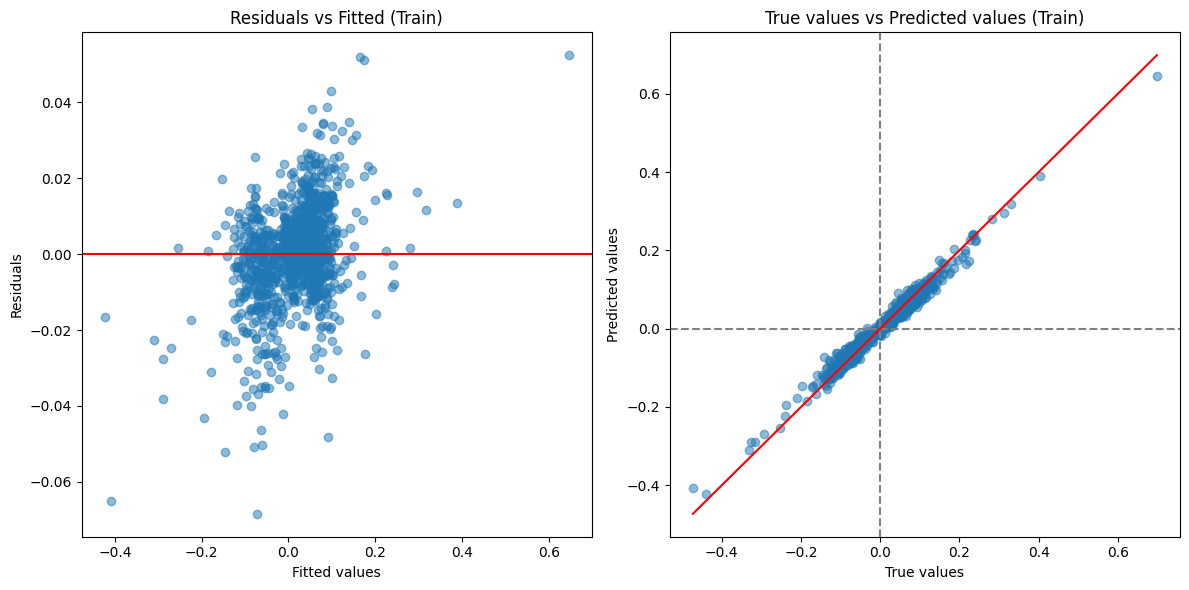

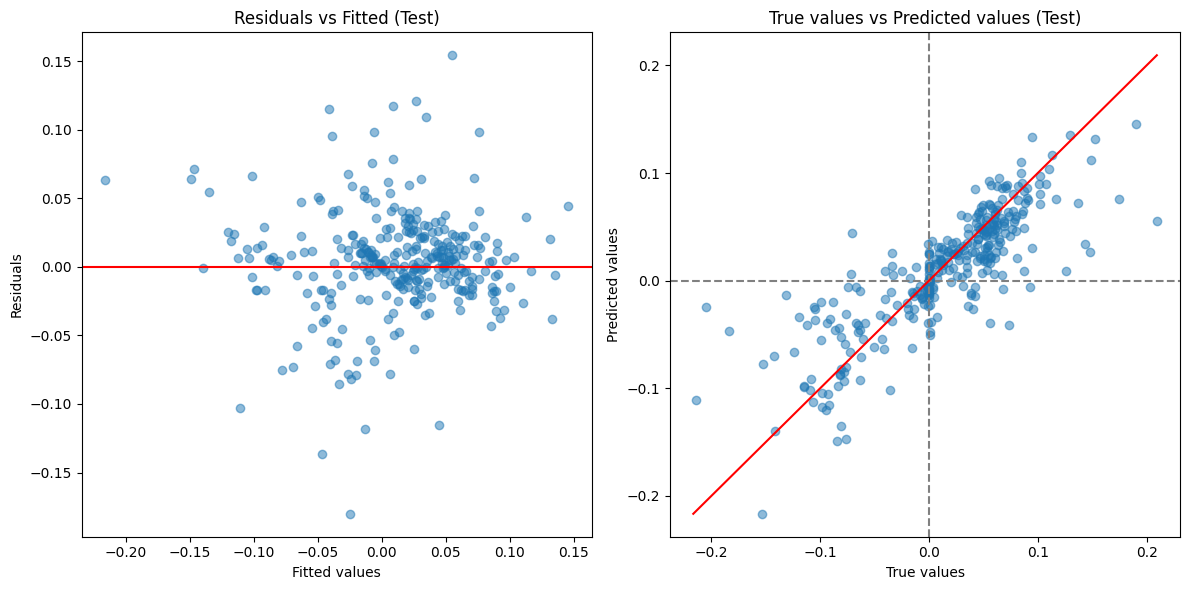

pass
None
Evaluation for (Train)
Max Error: 0.08077544650948525
Mean Absolute Error: 0.007114852344078033
Mean Squared Error for +wpa: 0.00015328968725613162
Mean Squared Error for -wpa: 8.71842888922954e-05
Regression Accuracy: 0.9225058004640371
Mean Squared Error: 0.00011770627096747733
Root Mean Squared Error: 0.010849252092539712
R-Squared: 0.9852741950605585
----------------------------
Evaluation for (Test)
Max Error: 0.5633393834957076
Mean Absolute Error: 0.02662836418994332
Mean Squared Error for +wpa: 0.004579353867614498
Mean Squared Error for -wpa: 0.0012206830606903184
Regression Accuracy: 0.8645640074211502
Mean Squared Error: 0.0027535829094905927
Root Mean Squared Error: 0.052474592990232834
R-Squared: 0.3920555266544986
----------------------------


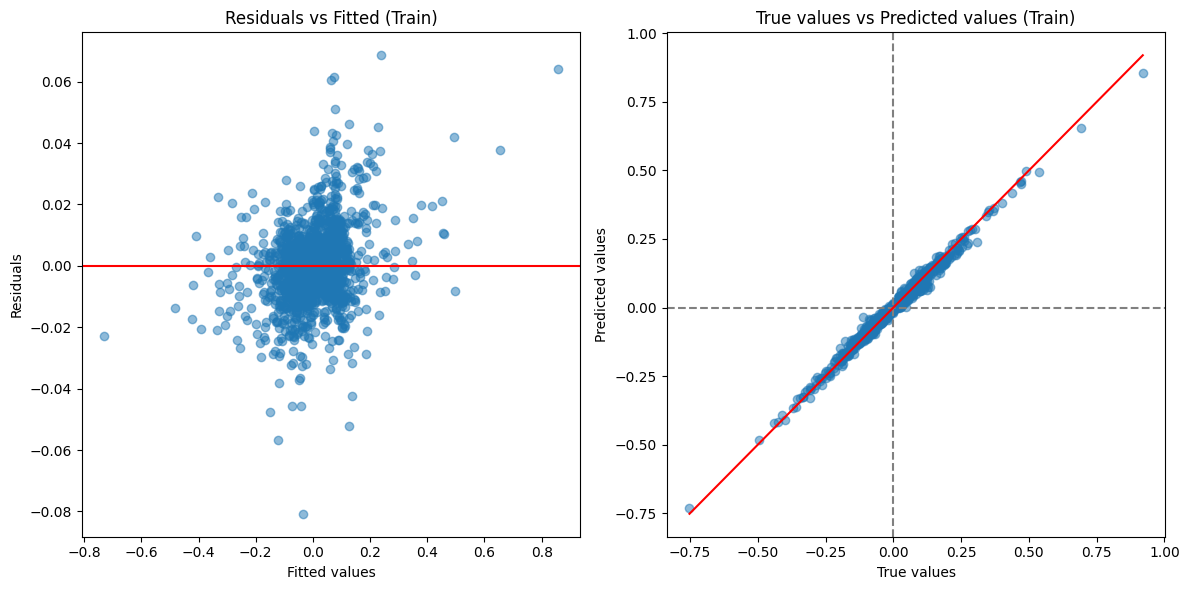

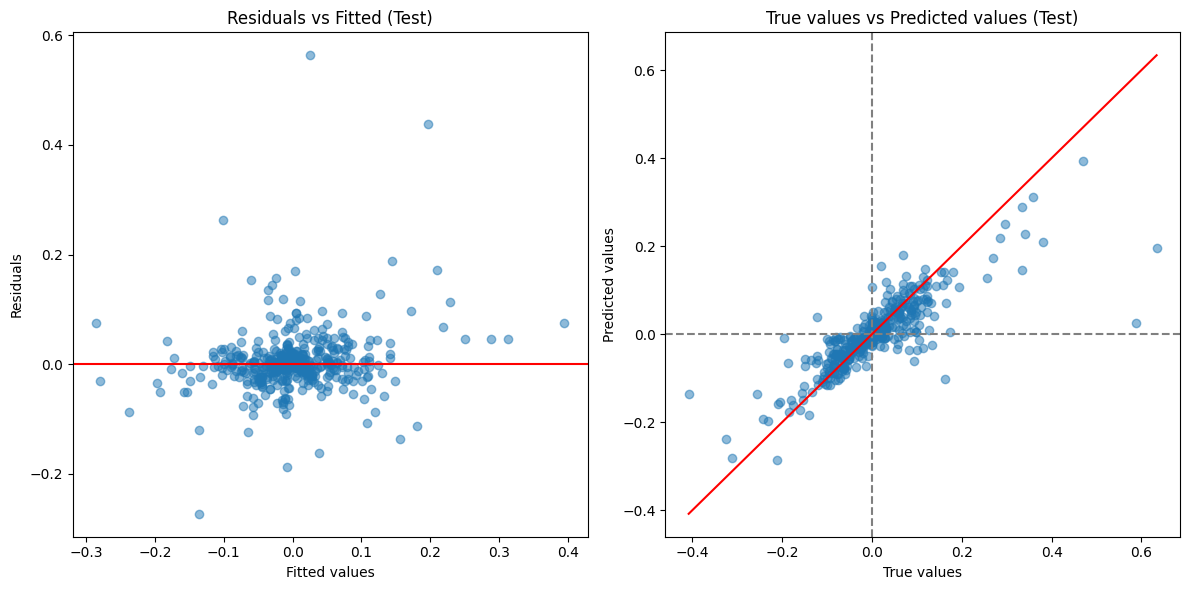

fg
None
Evaluation for (Train)
Max Error: 0.12170494987804412
Mean Absolute Error: 0.008184651320233539
Mean Squared Error for +wpa: 0.0001137545287665073
Mean Squared Error for -wpa: 0.0001859827046517727
Regression Accuracy: 0.9069212410501193
Mean Squared Error: 0.00014169612946154488
Root Mean Squared Error: 0.011903618334840247
R-Squared: 0.9655111312109094
----------------------------
Evaluation for (Test)
Max Error: 0.4773954974597931
Mean Absolute Error: 0.024677307612830362
Mean Squared Error for +wpa: 0.0011726877416693602
Mean Squared Error for -wpa: 0.0029054803992312845
Regression Accuracy: 0.7658282740676496
Mean Squared Error: 0.001859492810624954
Root Mean Squared Error: 0.04312183681877378
R-Squared: -0.05727824700019646
----------------------------


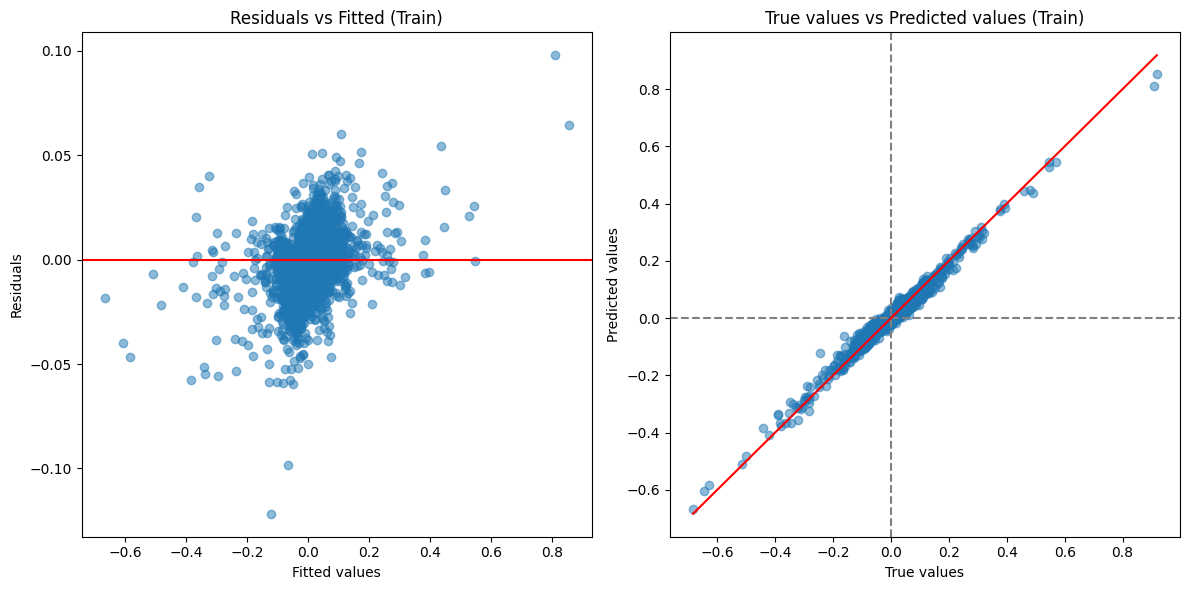

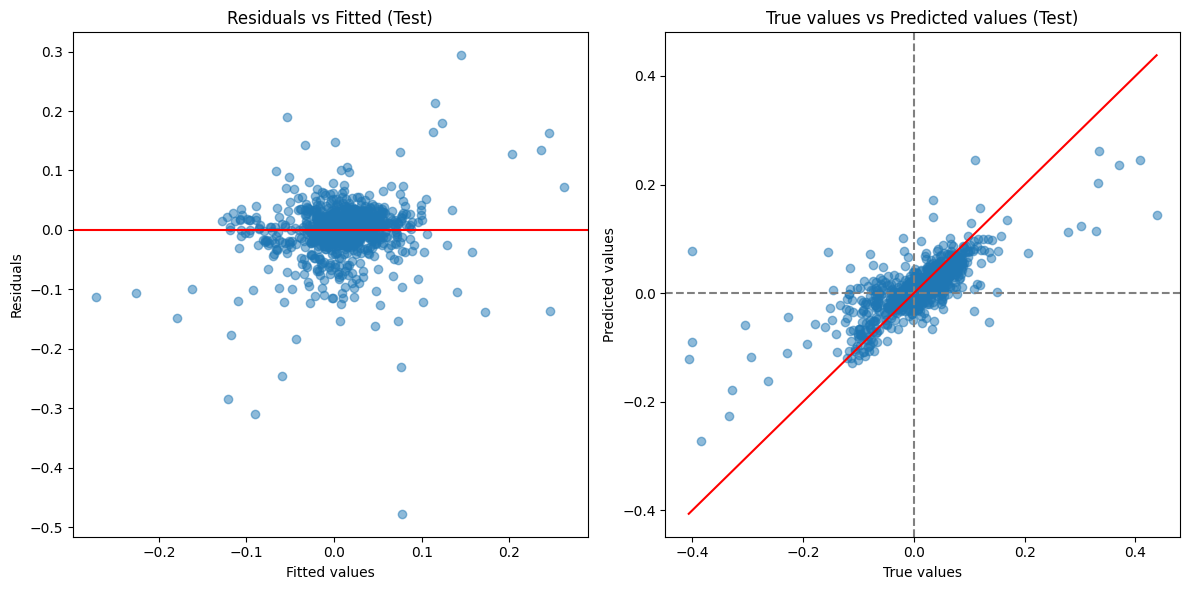

punt
None
Evaluation for (Train)
Max Error: 0.12386260149230954
Mean Absolute Error: 0.007771210510741997
Mean Squared Error for +wpa: 0.000118883252435777
Mean Squared Error for -wpa: 0.00013706359969195382
Regression Accuracy: 0.8542755787901419
Mean Squared Error: 0.00012743541541410737
Root Mean Squared Error: 0.011288729574850633
R-Squared: 0.9294706328952983
----------------------------
Evaluation for (Test)
Max Error: 0.8874007513206243
Mean Absolute Error: 0.015052570206596214
Mean Squared Error for +wpa: 0.0006126248867351726
Mean Squared Error for -wpa: 0.0012509399309104676
Regression Accuracy: 0.751680358476475
Mean Squared Error: 0.0009084236058619615
Root Mean Squared Error: 0.03014006645417295
R-Squared: 0.33898688646002506
----------------------------


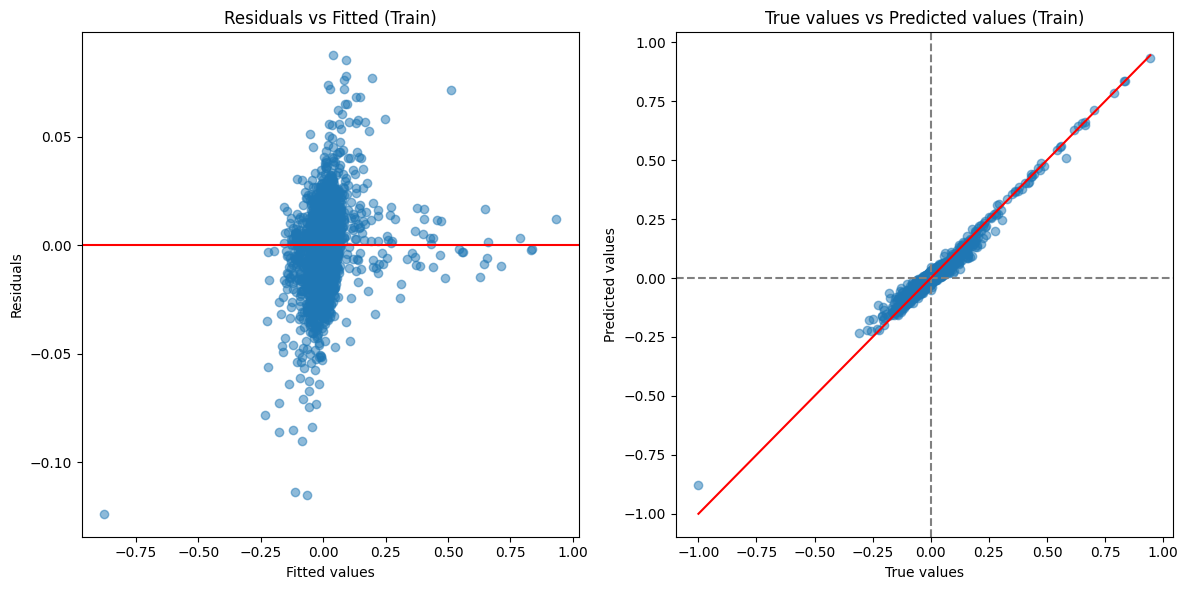

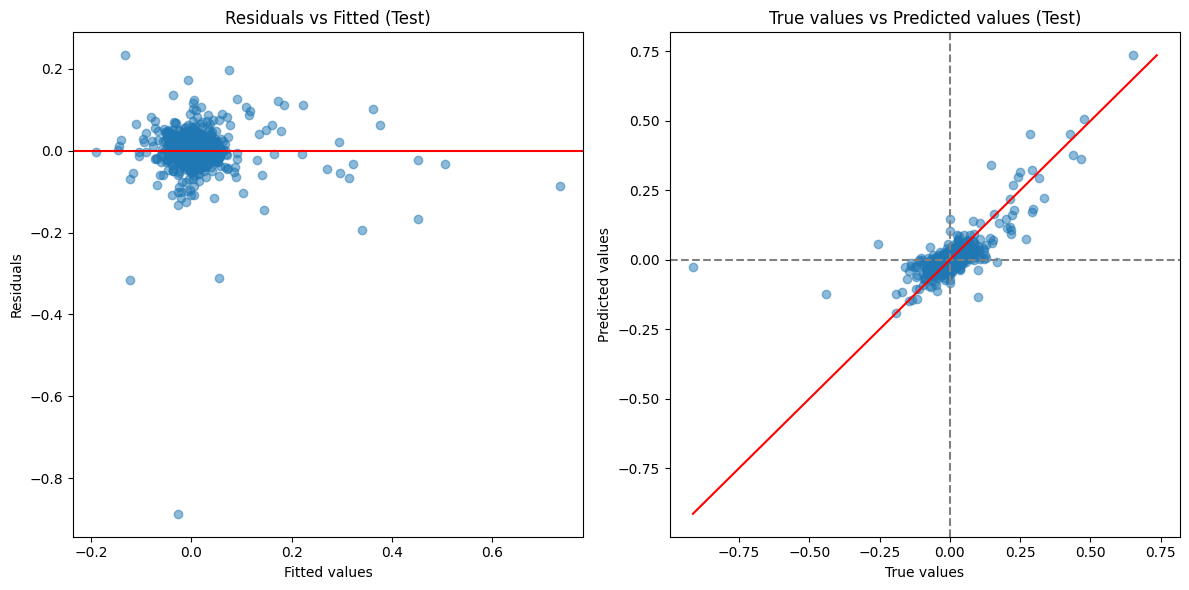

In [21]:


for (name, play_data), best_model in zip(partitioned_dataset, reg_models): 
    
    print(f"{name}")
    print(best_model.feature_names)
    y = play_data['wpa_avg'].to_numpy()
    X = play_data.drop('wpa_avg', axis=1)
    cols = X.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    xg = xgb.XGBRegressor(objective='reg:squarederror',random_state=44449999)
    
    
    cols = feature_selection(xg, X_train, y_train)
    X_train_sel, X_test_sel = X_train[cols], X_test[cols]
    
    
    re = regression_evaluator(cols)
    re.evaluate(best_model, X_train_sel, X_test_sel, y_train, y_test,clear=True, pr=True,dmat=True)
    
    
    

In [198]:
class robo_coach():
    
    def __init__(self, classifier_min_threshold = 0,classifier_max_threshold=0.99):
        self.classifier_min_threshold = classifier_min_threshold
        self.classifier_max_threshold = classifier_max_threshold
        
        
        self.fg_columns = ['year', 'yardline_100', 'half_seconds_remaining',
       'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'defteam_timeouts_remaining', 'score_differential', 'no_score_prob',
       'fg_prob', 'drive_play_count', 'spread_line', 'posteam_is_home',
       'wp_avg', 'wp_difference', 'posteam_pass_epa_per_sec']
        
        self.pass_columns = ['yardline_100', 'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'score_differential', 'no_score_prob', 'drive_play_count',
       'posteam_is_home', 'posteam_spread_line', 'wp_avg', 'wp_difference',
       'posteam_pass_epa_per_sec']
        
        self.run_columns = ['year', 'week', 'yardline_100', 'half_seconds_remaining',
       'game_seconds_remaining', 'drive', 'ydstogo', 'ydsnet',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'score_differential', 'no_score_prob', 'fg_prob', 'ep',
       'drive_play_count', 'spread_line', 'posteam_is_home',
       'posteam_spread_line', 'wp_avg', 'wp_difference',
       'posteam_rush_epa_per_sec', 'posteam_pass_epa_per_sec']
        
        self.punt_columns = ['yardline_100', 'half_seconds_remaining', 'game_seconds_remaining',
       'drive', 'ydstogo', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'score_differential', 'no_score_prob',
       'fg_prob', 'td_prob', 'spread_line', 'posteam_is_home', 'wp_avg',
       'wp_difference', 'posteam_pass_epa_per_sec']
        
        self.load_models()
     
        
    def set_cols(self, dataset):
        
        passing = partition(data,'pass')
        run = partition(data,'run')
        fg = partition(data,'field_goal')
        punt = partition(data,'punt')

        partitioned_dataset = [("run", run) , 
                               ("pass", passing), 
                               ("fg", fg), 
                               ("punt", punt)]
        
        for name, play_data in partitioned_dataset: 
            print(f"Setting {name} Columns...")

            y = play_data['wpa_avg'].to_numpy()
            X = play_data.drop('wpa_avg', axis=1)
            cols = X.columns
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            xg = xgb.XGBRegressor(objective='reg:squarederror',random_state=44449999)

            cols = feature_selection(xg, X_train, y_train)
            
            setattr(self, f"{name}_columns", cols)

    def load_data(self):
        
    
    def load_models(self):
        run_path = 'run_model_v2.model'
        pass_path = 'pass_model_v2.model'
        fg_path = 'fg_model_v2.model'
        punt_path = 'punt_model_v2.model'
        classifier_path = 'decision_tree_classifier.pkl'

        run_model = xgb.Booster()
        run_model.load_model(run_path)

        pass_model = xgb.Booster()
        pass_model.load_model(pass_path)

        fg_model = xgb.Booster()
        fg_model.load_model(fg_path)

        punt_model = xgb.Booster()
        punt_model.load_model(punt_path)
        

        with open(classifier_path, 'rb') as f:
            classifier = pickle.load(f)
            
        self.run_model = run_model
        self.pass_model = pass_model
        self.fg_model = fg_model
        self.punt_model = punt_model
        self.classifier = classifier
        self.classifier_columns = classifier.feature_names_in_.tolist()
        
        self.models = {
            "field_goal": (self.fg_model, self.fg_columns),
            "pass": (self.pass_model, self.pass_columns),
            "punt": (self.punt_model, self.punt_columns),
            "run": (self.run_model, self.run_columns),
        }
    
    def train_models(self):
        pass
    
    def get_classifier_predict_proba(self, X):
        
        X = X[self.classifier_columns]
        return self.classifier.predict_proba(X)
    
    def predict_wpa(self, df):
        
        suffix = '_wpa_pred'
        for play_type in self.models:
            model, cols = self.models[play_type]
            dmat = xgb.DMatrix(data=df[cols])
            df[f'{play_type}{suffix}'] = model.predict(dmat)
        
        return df
    
    def predict(self, X):
        
        def get_wpa_prediction(row, idx_to_possible_plays):
            suffix = '_wpa_pred'
            idx = row.name
            possible_plays = idx_to_possible_plays[idx]
            wpa_pred_cols = [f'{play_type}{suffix}' for play_type in possible_plays]
            preds = row[wpa_pred_cols]
            
            play = preds.idxmax().replace(suffix, "")
            wpa_pred = preds.max()
            
            return {idx : (play, wpa_pred)}
            
        
        X = X.reset_index()
        
        predict_proba = self.get_classifier_predict_proba(X)
        classes = self.classifier.classes_
        predictions = []
        
        threshold_exceeded = np.any(predict_proba > self.classifier_threshold, axis=1)
        
        theshold_not_exceeded = ~threshold_exceeded
        
        classifier_preds = np.where(threshold_exceeded)[0]
        
        idx_to_pred = {i: classes[np.argmax(predict_proba[i])] for i in classifier_preds}
        
        regressor_preds = np.where(theshold_not_exceeded)[0]
        
        idx_to_possible_plays = {i: [c for c in classes[np.where(predict_proba[i] > 0)[0]]] for i in regressor_preds}
    
        X_uncertain = X.iloc[regressor_preds,]
        
        X_uncertain = self.predict_wpa(X_uncertain)
        
        final_preds = X_uncertain.apply(get_wpa_prediction,idx_to_possible_plays=idx_to_possible_plays, axis=1)
               
        final_preds_master_dict = {}
        
        for item in final_preds:
            final_preds_master_dict.update(item)
        
        final_preds_master_dict.update(idx_to_pred)
        
        final_preds_list = [0] * len(final_preds_master_dict)
        
        for idx, val in final_preds_master_dict.items():
            final_preds_list[idx] = val
        
        return final_preds_list
            
        
        
    
    

In [189]:
dataset = pd.read_csv('fourth_down_dataset.csv')
dataset = dataset.dropna(subset=['play_type'])
dataset.drop(dataset[dataset['play_type'] == 'no_play'].index, inplace=True)
dataset.drop(dataset[dataset['play_type'] == 'qb_kneel'].index, inplace=True)
print(dataset['play_type'].value_counts())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rb = robo_coach()
preds = rb.predict(X_test)


play_type
punt          13390
field_goal     5762
pass           2694
run            1608
Name: count, dtype: int64


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_14628/3371842420.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{play_type}{suffix}'] = model.predict(dmat)
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_14628/3371842420.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{play_type}{suffix}'] = model.predict(dmat)
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_14628/3371842420.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Classification Report:
               precision    recall  f1-score   support

  field_goal       0.54      0.55      0.54        86
        pass       0.39      0.38      0.39       570
        punt       0.76      0.54      0.63       715
         run       0.21      0.35      0.27       330

    accuracy                           0.45      1701
   macro avg       0.48      0.46      0.46      1701
weighted avg       0.52      0.45      0.47      1701
 <class 'str'>


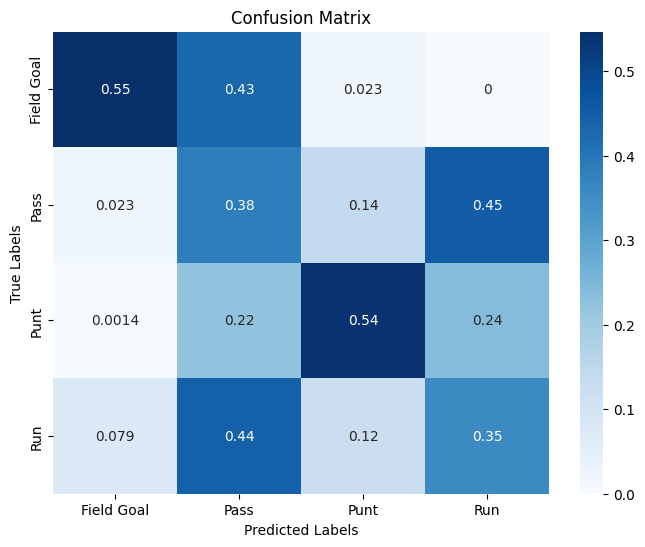

In [197]:
report = classification_report(y_test_reg, reg_preds)
conf_matrix = confusion_matrix(y_test_reg, reg_preds)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

print("Classification Report:\n", report ,type(report))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
Name: count, dtype: int64
['yardline_100' 'half_seconds_remaining' 'game_seconds_remaining'
 'ydstogo' 'ydsnet' 'fg_prob' 'td_prob' 'ep' 'drive_play_count'
 'posteam_is_home' 'posteam_spread_line' 'wp_avg']
['field_goal' 'pass' 'field_goal' ... 'punt' 'field_goal' 'punt']
Classification Report:
               precision    recall  f1-score   support

  field_goal       0.99      1.00      0.99      1148
        pass       0.78      0.69      0.73       580
        punt       0.96      0.97      0.97      2630
         run       0.69      0.74      0.71       333

    accuracy                           0.93      4691
   macro avg       0.86      0.85      0.85      4691
weighted avg       0.93      0.93      0.93      4691
 <class 'str'>


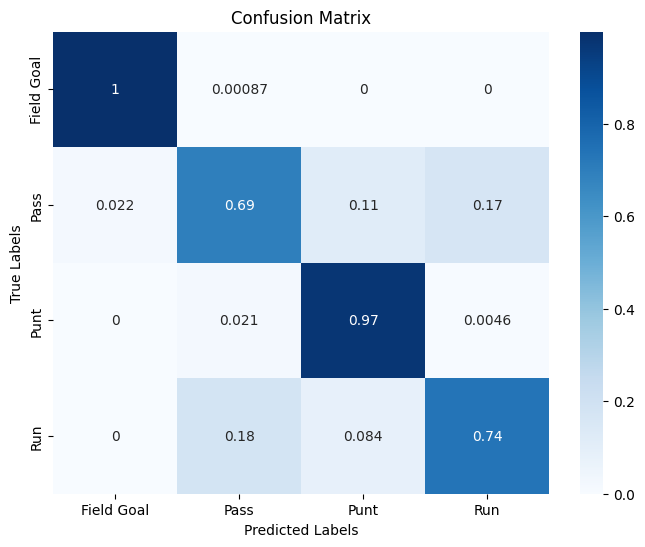

In [138]:
dataset = pd.read_csv('fourth_down_dataset.csv')
dataset = dataset.dropna(subset=['play_type'])
dataset.drop(dataset[dataset['play_type'] == 'no_play'].index, inplace=True)
dataset.drop(dataset[dataset['play_type'] == 'qb_kneel'].index, inplace=True)
print(dataset['play_type'].value_counts())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cols = classifier.feature_names_in_
print(cols)
y_pred = classifier.predict(X_test[cols])
proba = classifier.predict_proba(X_test[cols])

print(y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

print("Classification Report:\n", report ,type(report))
class_labels = ["Field Goal","Pass", 'Punt' , "Run"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()